In [1]:
import pandas as pd 
df = pd.read_csv('../data/us_congressional_record/us_congress_speeches_processed.csv')
df = df.sample(n=50000, random_state = 42)
df

,Unnamed: 0,doc,party,speech_year,doc_clean
691903,691903,"Speaker, I would like to express my strong su...",Republican,2005,like express support convey land use heliport ...
351367,351367,"Speaker, this bill, H R. 2277 authorizes $75,...",Democrat,1979,bill authorize airport airway trust fund year ...
250310,250310,"Speaker, I appreciate having this opportunity...",Democrat,1972,appreciate have opportunity discuss colleague ...
644446,644446,The gentleman is absolutely correct. I rememb...,Democrat,2000,gentleman remember friend say start road life ...
803736,803736,I thank the gentleman from Florida for some o...,Republican,2002,thank gentleman opportunity share passion view...
...,...,...,...,...,...
79650,79650,"Chairman, I rise in opposition to the amendme...",Democrat,1958,rise opposition amendment offer gentleman answ...
544086,544086,"Speaker, there is one central question that m...",Republican,1993,question answer people issue health care trust...
856936,856936,"Speaker, I very much appreciate the gentleman...",Republican,2003,appreciate gentleman come discuss tonight brin...
811229,811229,"Chairman, will the gentlewoman yield? Chairm...",Democrat,1997,gentlewoman yield like reemphasize gentlewoman...


In [2]:
import sys
sys.path.append('../gtm/')
from corpus import GTMCorpus
from gtm import GTM

# Create a GTMCorpus object
train_dataset = GTMCorpus(
    df, 
    prevalence = "~ party", # + C(speech_year) 
    content = "~ party" # + C(speech_year)
)

train_dataset.M_prevalence_covariates.shape

/home/germain/Documents/topic models/generalized_topic_model/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(50000, 2)

In [3]:
train_dataset.M_prevalence_covariates

array([[1., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [4]:
train_dataset.prevalence_colnames

['Intercept', 'party[T.Republican]']

In [5]:
# Train the model
tm = GTM(
    train_dataset, 
    n_topics=50,
    doc_topic_prior='dirichlet', # logistic_normal
    alpha=0.1,
    prevalence_covariates_regularization=0.1,
    update_prior=True,
    encoder_hidden_layers=[], # structure of the encoder neural net
    decoder_hidden_layers=[300], # structure of the decoder neural net
    num_epochs=5,
    print_every=10000,
    log_every=1,
    w_prior=None,
    batch_size=250
)


Epoch   1	Mean Training Loss:22.2669283

Topic_0: ['gentleman', 'bill', 'go', 'time', 'year']
Topic_1: ['bill', 'time', 'gentleman', 'year', 'make']
Topic_2: ['bill', 'go', 'year', 'gentleman', 'time']
Topic_3: ['gentleman', 'bill', 'amendment', 'go', 'say']
Topic_4: ['bill', 'year', 'say', 'gentleman', 'time']
Topic_5: ['bill', 'make', 'amendment', 'time', 'gentleman']
Topic_6: ['bill', 'gentleman', 'time', 'make', 'say']
Topic_7: ['people', 'time', 'say', 'year', 'member']
Topic_8: ['gentleman', 'bill', 'time', 'year', 'go']
Topic_9: ['gentleman', 'bill', 'year', 'make', 'go']
Topic_10: ['year', 'gentleman', 'time', 'people', 'say']
Topic_11: ['gentleman', 'go', 'bill', 'time', 'people']
Topic_12: ['bill', 'year', 'make', 'time', 'say']
Topic_13: ['gentleman', 'bill', 'go', 'say', 'make']
Topic_14: ['time', 'amendment', 'say', 'year', 'bill']
Topic_15: ['bill', 'gentleman', 'say', 'amendment', 'time']
Topic_16: ['bill', 'year', 'people', 'go', 'say']
Topic_17: ['make', 'say', 'bill'


Epoch   4	Mean Training Loss:3.7232896

Topic_0: ['price', 'producer', 'farmer', 'market', 'import']
Topic_1: ['gentleman', 'yield', 'consent', 'remark', 'thank']
Topic_2: ['gentleman', 'yield', 'amendment', 'tempore', 'minute']
Topic_3: ['gentleman', 'yield', 'amendment', 'thank', 'think']
Topic_4: ['gentleman', 'tempore', 'amendment', 'yield', 'consent']
Topic_5: ['gentleman', 'yield', 'amendment', 'bill', 'thank']
Topic_6: ['amendment', 'fund', 'program', 'gentleman', 'funding']
Topic_7: ['right', 'violence', 'peace', 'war', 'democracy']
Topic_8: ['kid', 'gentleman', 'talk', 'get', 'go']
Topic_9: ['thereto', 'reconsider', 'consent', 'amend', 'amendment']
Topic_10: ['care', 'health', 'insurance', 'coverage', 'senior']
Topic_11: ['honor', 'tribute', 'passing', 'sympathy', 'condolence']
Topic_12: ['program', 'fund', 'increase', 'income', 'project']
Topic_13: ['gentleman', 'price', 'yield', 'farmer', 'tax']
Topic_14: ['student', 'teacher', 'school', 'education', 'college']
Topic_15: ['

In [6]:
# Assess the quality of the learned word embeddings 
# Top 8 closest words to a specific word

import torch
import torch.nn.functional as F

specific_word = 'terrorist'

word_id = [i for i,w in enumerate(train_dataset.vocab) if w == specific_word][0]

words = tm.AutoEncoder.decoder['dec_1'].weight.T

logit = torch.matmul(words.T[word_id], words)

beta = F.softmax(logit)

tm.AutoEncoder.eval()
topic_words = []
vals, indices = torch.topk(beta, 8)
vals = vals.cpu().tolist()
indices = indices.cpu().tolist()
[tm.id2token[idx] for idx in indices]

/tmp/ipykernel_13835/3811166158.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  beta = F.softmax(logit)


['terrorist',
 'abortionist',
 'abortion',
 'murder',
 'prisoner',
 'bombing',
 'criminal',
 'terror']

In [7]:
dfc = tm.estimate_effect(train_dataset, n_samples=10, topic_ids=[18,20,43])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.66it/s]


In [9]:
dfc

,topic,covariate,mean,sd
0,18,Intercept,0.020056,0.000620
1,18,party[T.Republican],-0.000164,0.001083
2,20,Intercept,0.019722,0.000582
3,20,party[T.Republican],0.000272,0.000819
4,43,Intercept,0.020066,0.000612
5,43,party[T.Republican],0.000126,0.000849


In [ ]:
import statsmodels.api as sm
Y = tm.get_doc_topic_distribution(train_dataset)
X = train_dataset.M_prevalence_covariates
model = sm.OLS(Y[:,43],X)
results = model.fit()
covs = train_dataset.prevalence_colnames
pd.DataFrame([covs, results.params])

In [14]:
tm.get_top_docs(train_dataset, topic_id = 47)

Topic: 47 | Document index: 44904 | Topic share: 0.8581517338752747
 In the Office of the Secretary we recommend $4, 480, 000, an increase of $380, 000 over 1962, and a cut of $180, 000. The Office of the Secretary requested an increase of personnel of 36 including 6 that had been transferred from the Bureau of the Mint over to the Office of Secretary. The policymaking powers have been transferred from the Bureau of the Mint to the Secretary's Office, which our committee feels is a very proper change; and as a result of that change the six employees have been transferred. They are new in the Secretary's budget, but are not new in the whole budget; they have simply been transferred. In addition he requests six positions for the civil defense activities. As a matter of fact, each division is requesting certain civil defense employees. Our committee felt, and I understand it is to be the policy of the entire Appropriations Committee, that all of these civil defense activities will be stri

In [ ]:
ldavis_format = tm.get_ldavis_data_format(train_dataset)
import pyLDAvis
gtm_vis_data = pyLDAvis.prepare(**ldavis_format, sort_topics=False)
pyLDAvis.display(gtm_vis_data)

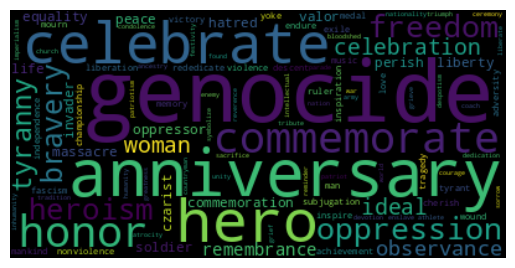

In [11]:
tm.plot_wordcloud(topic_id = 18)